# DS24 Course Project

**Submitted by:**
1.   Haleema **KHAN**
2.   Lisa **DOLLMANN**
3.   Osama **JAMIL**




## Dataset

You will examine the ProPublica COMPAS dataset, which consists of all criminal defendants who were subject to COMPAS screening in Broward County, Florida, during 2013 and 2014. For each defendant, various information fields (‘features’) were also gathered by ProPublica. Broadly, these fields are related to the defendant’s demographic information (e.g., gender and race), criminal history (e.g., the number of prior offenses) and administrative information about the case (e.g., the case number, arrest date, risk of recidivism predicted by the COMPAS tool). Finally, the dataset also contains information about whether the defendant did actually recidivate or not.

The COMPAS score uses answers to 137 questions to assign a risk score to defendants -- essentially a probability of re-arrest. The actual output is two-fold: a risk rating of 1-10 and a "low", "medium", or "high" risk label.

Link to dataset: https://github.com/propublica/compas-analysis

The file we will analyze is: compas-scores-two-years.csv

Link to the ProPublica article:

https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing


## Project goal

The project has three parts:

- The COMPAS scores have been shown to have biases against certain racial groups. Analyze the dataset to highlight these biases.  

- Based on the features in the COMPAS dataset, train classifiers to predict who will re-offend (hint: no need to use all features, just the ones you find relevant).  Study if your classifiers are more or less fair than the COMPAS classifier.

- Build a fair classifier (last lecture will cover fair classification techniques). Is excluding the race from the feature set enough?


## Download the data

We first need to load the data from the ProPublica repo:
https://github.com/propublica/compas-analysis


In [ ]:
import urllib
import os,sys
import numpy as np
import pandas as pd

from sklearn import feature_extraction
from sklearn import preprocessing
from random import seed, shuffle

SEED = 1234
seed(SEED)
np.random.seed(SEED)

def check_data_file(fname):
    files = os.listdir(".") # get the current directory listing
    print("Looking for file '%s' in the current directory...",fname)

    if fname not in files:
        print("'%s' not found! Downloading from GitHub...",fname)
        addr = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"
        response = urllib.request.urlopen(addr)
        data = response.read()
        fileOut = open(fname, "wb")
        fileOut.write(data)
        fileOut.close()
        print("'%s' download and saved locally..",fname)
    else:
        print("File found in current directory..")

COMPAS_INPUT_FILE = "compas-scores-two-years.csv"
check_data_file(COMPAS_INPUT_FILE)

Looking for file '%s' in the current directory... compas-scores-two-years.csv
'%s' not found! Downloading from GitHub... compas-scores-two-years.csv
'%s' download and saved locally.. compas-scores-two-years.csv


## Load data and clean it up

In [ ]:
# load the file
df = pd.read_csv(COMPAS_INPUT_FILE)
print(f"Initial dimesnions of the data: {df.shape}")
print(f"Features in dataset: {df.columns}")

Initial dimesnions of the data: (7214, 53)
Features in dataset: Index(['id', 'name', 'first', 'last', 'compas_screening_date', 'sex', 'dob',
       'age', 'age_cat', 'race', 'juv_fel_count', 'decile_score',
       'juv_misd_count', 'juv_other_count', 'priors_count',
       'days_b_screening_arrest', 'c_jail_in', 'c_jail_out', 'c_case_number',
       'c_offense_date', 'c_arrest_date', 'c_days_from_compas',
       'c_charge_degree', 'c_charge_desc', 'is_recid', 'r_case_number',
       'r_charge_degree', 'r_days_from_arrest', 'r_offense_date',
       'r_charge_desc', 'r_jail_in', 'r_jail_out', 'violent_recid',
       'is_violent_recid', 'vr_case_number', 'vr_charge_degree',
       'vr_offense_date', 'vr_charge_desc', 'type_of_assessment',
       'decile_score.1', 'score_text', 'screening_date',
       'v_type_of_assessment', 'v_decile_score', 'v_score_text',
       'v_screening_date', 'in_custody', 'out_custody', 'priors_count.1',
       'start', 'end', 'event', 'two_year_recid'],
      d

In [ ]:
df.head(5)

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0


In [ ]:
df = df.dropna(subset=["days_b_screening_arrest"]) # dropping missing vals
print(f"Dimensions after cleaning up the missing values: {df.shape}")


df = df[
    (df.days_b_screening_arrest <= 30) &
    (df.days_b_screening_arrest >= -30) &
    (df.is_recid != -1) &
    (df.c_charge_degree != 'O') &
    (df.score_text != 'N/A')
]

df.reset_index(inplace=True, drop=True) # renumber the rows from 0 again
print(f"Dimensions after cleaning up the data according to Propublica guidelines: {df.shape}")


Dimensions after cleaning up the missing values: (6907, 53)
Dimensions after cleaning up the data according to Propublica guidelines: (6172, 53)


In [ ]:
df.groupby('race')['priors_count'].mean()

df['c_charge_degree']

0       F
1       F
2       F
3       M
4       F
       ..
6167    F
6168    F
6169    F
6170    M
6171    F
Name: c_charge_degree, Length: 6172, dtype: object

In [ ]:
df.describe() # generates descriptive statistics (e.g., to check for outliers)

,id,age,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_days_from_compas,is_recid,r_days_from_arrest,violent_recid,is_violent_recid,decile_score.1,v_decile_score,priors_count.1,start,end,event,two_year_recid
count,6172.000000,6172.000000,6172.000000,6172.000000,6172.000000,6172.000000,6172.000000,6172.000000,6172.000000,6172.000000,1997.000000,0.0,6172.000000,6172.000000,6172.000000,6172.000000,6172.000000,6172.000000,6172.000000,6172.000000
mean,5509.259883,34.534511,0.059300,4.418503,0.091218,0.110661,3.246436,-1.740279,24.903273,0.484446,20.100651,NaN,0.112119,4.418503,3.641769,3.246436,13.316753,555.049417,0.389825,0.455120
std,3171.878516,11.730938,0.463599,2.839463,0.497872,0.470731,4.743770,5.084709,276.812982,0.499799,76.543499,NaN,0.315539,2.839463,2.488768,4.743770,50.138185,400.258400,0.487750,0.498022
min,1.000000,18.000000,0.000000,1.000000,0.000000,0.000000,0.000000,-30.000000,0.000000,0.000000,-1.000000,NaN,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2753.750000,25.000000,0.000000,2.000000,0.000000,0.000000,0.000000,-1.000000,1.000000,0.000000,0.000000,NaN,0.000000,2.000000,1.000000,0.000000,0.000000,148.000000,0.000000,0.000000
50%,5521.000000,31.000000,0.000000,4.000000,0.000000,0.000000,1.000000,-1.000000,1.000000,0.000000,0.000000,NaN,0.000000,4.000000,3.000000,1.000000,0.000000,539.500000,0.000000,0.000000
75%,8225.250000,42.000000,0.000000,7.000000,0.000000,0.000000,4.000000,-1.000000,1.000000,1.000000,1.000000,NaN,0.000000,7.000000,5.000000,4.000000,3.000000,914.000000,1.000000,1.000000
max,11001.000000,96.000000,20.000000,10.000000,13.000000,9.000000,38.000000,30.000000,9485.000000,1.000000,993.000000,NaN,1.000000,10.000000,10.000000,38.000000,937.000000,1186.000000,1.000000,1.000000


From the above results, we found that

*   The dataset contains information about 7214 convicts.
*   The dataset contains 53 features
*   The dataset contains 307 missing values and we removed them.
*   We found that there are alot of outliers in the dataset. Over 75% of the data is composed of people we have 4 priors or less. While 50% of the data has 1 or no prior. An interesting fact was found related to juveniele feloncy count too. over 75% data had no juveniele record.

---
We found from propublica that not all of the rows are useable for the first round of analysis.There are a number of reasons remove rows because of missing data:

*   If the charge date of a defendants Compas scored crime was not within 30 days from when the person was arrested, we assume that because of data quality reasons, that we do not have the right offense.
*   We coded the recidivist flag -- is_recid -- to be -1 if we could not find a compas case at all.
*   In a similar vein, ordinary traffic offenses -- those with a c_charge_degree of 'O' -- will not result in Jail time are removed (only two of them).
*   We filtered the underlying data from Broward county to include only those rows representing people who had either recidivated in two years, or had at least two years outside of a correctional facility.









In [ ]:
# Conversion to dictionary with np arrays for ease in future
data = df.to_dict('list')
for k in data.keys():
    data[k] = np.array(data[k])

## Basic analysis of demographics

In [ ]:
print(f"Races present in the dataset: {df.race.unique()}")

Races present in the dataset: ['Other' 'African-American' 'Caucasian' 'Hispanic' 'Asian'
 'Native American']


In [ ]:
print(f"Number of people by age category: ")
df.age_cat.value_counts()

Number of people by age category: 


age_cat
25 - 45            3532
Less than 25       1347
Greater than 45    1293
Name: count, dtype: int64

In [ ]:
print(f"Number of people by race:")
df.race.value_counts()

Number of people by race:


race
African-American    3175
Caucasian           2103
Hispanic             509
Other                343
Asian                 31
Native American       11
Name: count, dtype: int64

In [ ]:
print(f"Number of people by COMPAS score:")
df.decile_score.value_counts()

Number of people by COMPAS score:


decile_score
1     1286
2      822
4      666
3      647
5      582
6      529
7      496
9      420
8      420
10     304
Name: count, dtype: int64

In [ ]:
print(f"Number of people by COMPAS risk category: ")
df.score_text.value_counts()

Number of people by COMPAS risk category: 


score_text
Low       3421
Medium    1607
High      1144
Name: count, dtype: int64

## Basic investigations of gender and race bias in COMPAS scores

decile_score -- is the score given by the COMPAS algorithm that estimates the risk to re-offend.

score_text -- is the level of risk: Low, Medium, High

two_years_recid -- is the ground truth data on whether the offender recidivated or not

- What is the mean COMPAS score (decile_score) per race and gender?

- What is the distribution (histogram) of decile_score per race and gender?

The two_year_recid field records whether or not each person was re-arrested for a violent offense within two years, which is what COMPAS is trying to predict.

- How many people were re-arrested?

- Compute the recidivism (i.e., people that got re-arrested) rates by race and gender

- What is the accuracy of the COMPAS scores to predict recidivism

- Is the accuracy higher/lower if we look at particular races/genders?

- What about false positives and false negatives?


In [ ]:
print("Mean COMPAS score (decile_score) per race and gender")
pd.crosstab([df['race'], df['sex']],df['decile_score'])

Mean COMPAS score (decile_score) per race and gender


decile_score              1    2    3    4    5    6    7    8    9    10
race             sex                                                     
African-American Female   77   80   61   59   69   55   50   38   38   22
                 Male    288  266  237  278  254  263  293  263  279  205
Asian            Female    1    0    1    0    0    0    0    0    0    0
                 Male     14    4    4    0    1    2    1    2    0    1
Caucasian        Female  137   64   56   41   52   53   29   18   14   18
                 Male    468  257  182  202  148  107   84   78   63   32
Hispanic         Female   22   20   18   15    2    3    1    0    1    0
                 Male    137   69   55   32   37   24   27   14   16   16
Native American  Female    0    0    0    0    0    0    1    0    0    1
                 Male      0    2    1    0    0    2    1    0    2    1
Other            Female   24   11    4    8    4    3    3    0    0    1
                 Male    118   49   28   31   15   17    6    7    7    7

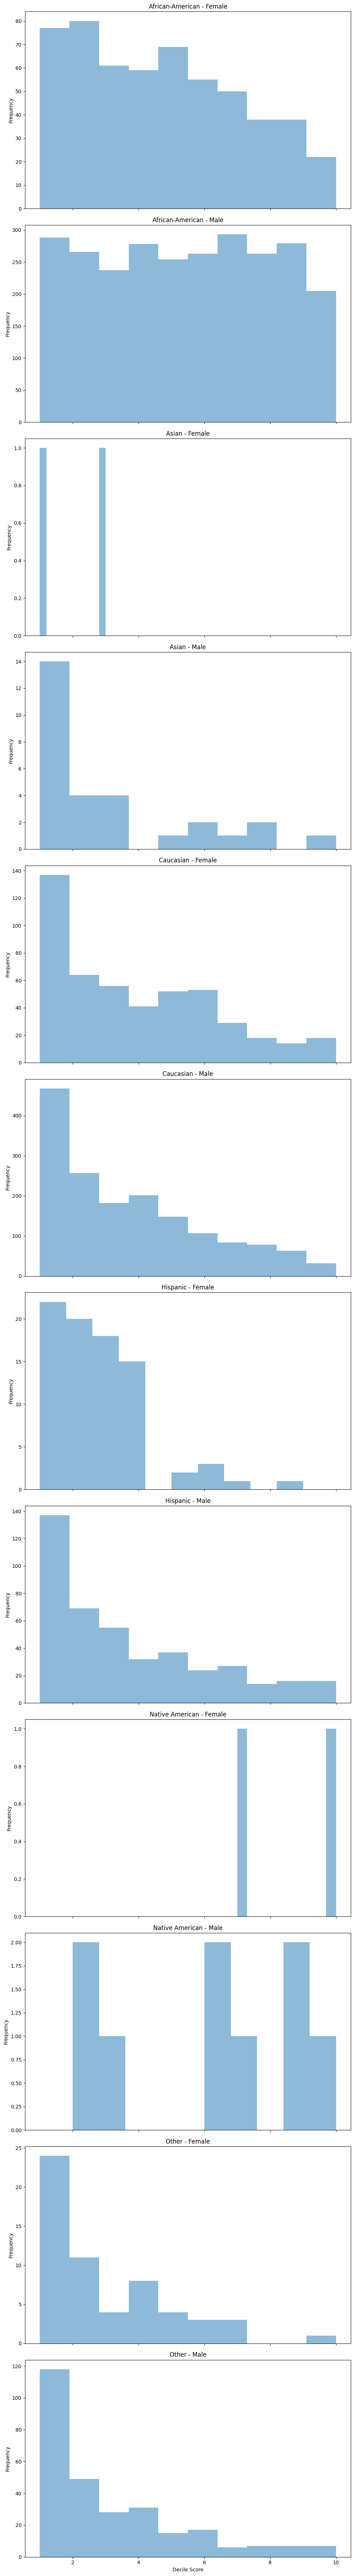

In [ ]:
import matplotlib.pyplot as plt
groups = df.groupby(['race', 'sex'])

# Plot histograms for decile score per race per gender
fig, axes = plt.subplots(len(groups), 1, figsize=(10, 6*len(groups)), sharex=True)

for i, ((race, sex), group) in enumerate(groups):
    ax = axes[i]
    group['decile_score'].plot(kind='hist', bins=10, alpha=0.5, ax=ax, title=f'{race} - {sex}')
    ax.set_xlabel('Decile Score')
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [ ]:
print(f"Number of perople who were rearrested: {len(df[df.two_year_recid == 1])}")

Number of perople who were rearrested: 2809


In [ ]:
print("Recidivism per race and gender:")
score_race = pd.crosstab([df['race'], df['sex']],df['two_year_recid'])
score_race['Recidivism'] = score_race[1] / score_race.sum(axis=1)
score_race

Recidivism per race and gender:


two_year_recid              0     1  Recidivism
race             sex                           
African-American Female   346   203    0.369763
                 Male    1168  1458    0.555217
Asian            Female     1     1    0.500000
                 Male      22     7    0.241379
Caucasian        Female   312   170    0.352697
                 Male     969   652    0.402221
Hispanic         Female    56    26    0.317073
                 Male     264   163    0.381733
Native American  Female     0     2    1.000000
                 Male       6     3    0.333333
Other            Female    47    11    0.189655
                 Male     172   113    0.396491

In [ ]:
# COMPAS recidivism confusion matrix
df['guessed_recid'] = df.score_text != 'Low'
df['actual_recid'] = df.two_year_recid == 1
true_predictions = len(df[df['actual_recid'] == df['guessed_recid']])
print(f"Accuracy of Compas Score: {true_predictions/len(df)}")
print("Confusion matrix to observe TP, TN, FP, FN: " )

cm = pd.crosstab(df.actual_recid, df.guessed_recid)
cm # for "confusion matrix"

Accuracy of Compas Score: 0.6607258587167855
Confusion matrix to observe TP, TN, FP, FN: 


guessed_recid,False,True
actual_recid,,
False,2345,1018
True,1076,1733


From the above results, it is evident that African Americans and Caucasians are the two biggest racial groups in the dataset. For simplicity, we will focus on these two for further research.

In [ ]:
# cm is a confusion matrix. The rows are guessed, the columns are actual
def print_ppv_fpv(cm):
    TN = cm[False][False]
    TP = cm[True][True]
    FN = cm[True][False]
    FP = cm[False][True]
    print('Accuracy: ', (TP + TN) / (TP + TN + FP + FN))
    print('PPV: ', TP / (TP + FP))
    print('TPR: ', TP / (TP + FN))
    print('FPR: ', FP / (FP + TN))
    print('FNR: ', FN / (FN + TP))

In [ ]:
print('White')
subset = df[df.race == 'Caucasian']
cm = pd.crosstab(subset.guessed_recid, subset.actual_recid, rownames=['guessed'], colnames=['actual'])
print_ppv_fpv(cm)
cm


White
Accuracy:  0.6718972895863052
PPV:  0.5948275862068966
TPR:  0.5036496350364964
FPR:  0.22014051522248243
FNR:  0.49635036496350365


actual,False,True
guessed,,
False,999,408
True,282,414


In [ ]:
print('Black')
subset = df[df.race == 'African-American']
cm = pd.crosstab(subset.guessed_recid, subset.actual_recid, rownames=['guessed'], colnames=['actual'])
print_ppv_fpv(cm)
cm

Black
Accuracy:  0.6491338582677165
PPV:  0.6495352651722253
TPR:  0.7152317880794702
FPR:  0.4233817701453104
FNR:  0.2847682119205298


actual,False,True
guessed,,
False,873,473
True,641,1188


It is very clear from the above results that the false positive rate for black people is much higher than of white people. While in the case of false negatives, this is reversed. This shows that model shows leniency towards white people and is much harsher in prediction when it comes to blacks. Model is lenient not only in classification, but also in misclassification.

The following 3 statistics show that African-Americans commited on average more crimes before, they commited a higher rate of felony and the average of recidivism was higher.

In [ ]:
print("Average prior count per race")
print()
df.groupby('race')['priors_count'].mean()

Average prior count per race



race
African-American    4.238110
Asian               1.354839
Caucasian           2.289111
Hispanic            2.100196
Native American     5.181818
Other               1.746356
Name: priors_count, dtype: float64

In [ ]:
print("Amount of felony and misdeamor per race")
print()
df.groupby(['race','c_charge_degree'])['id'].count()

Amount of felony and misdeamor per race



race              c_charge_degree
African-American  F                  2196
                  M                   979
Asian             F                    19
                  M                    12
Caucasian         F                  1244
                  M                   859
Hispanic          F                   291
                  M                   218
Native American   F                     7
                  M                     4
Other             F                   213
                  M                   130
Name: id, dtype: int64

In [ ]:
print("Average two year recid per race")
print()
df.groupby('race')["two_year_recid"].mean()

Average two year recid per race



race
African-American    0.523150
Asian               0.258065
Caucasian           0.390870
Hispanic            0.371316
Native American     0.454545
Other               0.361516
Name: two_year_recid, dtype: float64

In [ ]:
pip install fairlearn #install fairlearn libraries which we use for comparing fairness

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 234.1/234.1 kB 4.8 MB/s eta 0:00:00


# Helper Functions

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score
from sklearn.calibration import calibration_curve
from scipy.stats import chi2_contingency

import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
from fairlearn.metrics import demographic_parity_difference, demographic_parity_ratio, equalized_odds_difference, equalized_odds_ratio



def print_metrics(guessed, actual):
    cm = pd.crosstab(guessed, actual, rownames=['guessed'], colnames=['actual'])
    print(cm)
    print()
    print_ppv_fpv(cm)

def roc_curve_plot(X_test, y_test):
  scores = model.predict_proba(X_test)
  fpr, tpr, thresholds = roc_curve(y_test, scores[:,1])

  plt.plot(fpr, tpr)

  plt.title('ROC overall population')
  plt.xlabel("FPR")
  plt.ylabel("TPR")
  plt.show()

  print("ROC AUC: ", roc_auc_score(y_test, scores[:,1]))

def roc_curve_both_plot(X_test_b, y_test_b, X_test_w, y_test_w):

  scores_b = model.predict_proba(X_test_b) #blue
  fpr_b, tpr_b, thresholds_b = roc_curve(y_test_b, scores_b[:,1])

  plt.plot(fpr_b, tpr_b, label='Black')

  scores_w = model.predict_proba(X_test_w) # orange
  fpr_w, tpr_w, thresholds_W = roc_curve(y_test_w, scores_w[:,1])

  plt.plot(fpr_w, tpr_w, label='White')

  plt.title('ROC overall population')
  plt.legend()
  plt.xlabel("FPR")
  plt.ylabel("TPR")
  plt.show()

  print("ROC AUC Black: ", roc_auc_score(y_test_b, scores_b[:,1]))
  print("ROC AUC White: ", roc_auc_score(y_test_w, scores_w[:,1]))

  return scores_b, scores_w

def fairness_classifier(scores_b, scores_w, y_test_b, y_test_w):

  threshold_common = 0.5

  pred_b = scores_b[:,1] >= threshold_common
  pred_w = scores_w[:,1] >= threshold_common

  fpr_b, tpr_b, thresholds_b = roc_curve(y_test_b, pred_b)#blue

  plt.plot(fpr_b, tpr_b, label='Black')

  fpr_w, tpr_w, thresholds_W = roc_curve(y_test_w, pred_w) # orange

  plt.plot(fpr_w, tpr_w, label='White')

  plt.title('ROC overall population with 0.5 threshold')
  plt.legend()
  plt.xlabel("FPR")
  plt.ylabel("TPR")
  plt.show()


  # TODO: Insert your code below this line
  print("Black")
  print_metrics(pred_b, y_test_b.astype(bool))
  print("White")
  print_metrics(pred_w, y_test_w.astype(bool))

def calibration_plot(X_test, y_test):

  # TODO: Uncomment and complete the code below
  scores = model.predict_proba(X_test)
  prob_true, prob_pred = calibration_curve(y_test, scores[:,1])


  fig, ax = plt.subplots()
  # only this line is calibration curves
  plt.plot(prob_pred,prob_true, marker='o', linewidth=1, label='all')

  # reference line, legends, and axis labels
  line = mlines.Line2D([0, 1], [0, 1], color='black')
  transform = ax.transAxes
  line.set_transform(transform)
  ax.add_line(line)
  fig.suptitle('Calibration plot for the classifier (overall)')
  ax.set_xlabel('Predicted probability')
  ax.set_ylabel('True probability in each bin')
  plt.legend()
  plt.show()

def calibration_plot_both(X_test_b, y_test_b, X_test_w, y_test_w):
  scores = model.predict_proba(X_test_b)
  prob_true_b, prob_pred_b = calibration_curve(y_test_b, scores[:,1], n_bins=10)
  scores = model.predict_proba(X_test_w)
  prob_true_w, prob_pred_w = calibration_curve(y_test_w, scores[:,1], n_bins=10)


  fig, ax = plt.subplots()
  # only this line is calibration curves
  plt.plot(prob_pred_b,prob_true_b, marker='o', linewidth=1, label='Blacks')
  plt.plot(prob_pred_w,prob_true_w, marker='o', linewidth=1, label='Whites')

  # reference line, legends, and axis labels
  line = mlines.Line2D([0, 1], [0, 1], color='black')
  transform = ax.transAxes
  line.set_transform(transform)
  ax.add_line(line)
  fig.suptitle('Calibration plot for the classifier (overall)')
  ax.set_xlabel('Predicted probability')
  ax.set_ylabel('True probability in each bin')
  plt.legend()
  plt.show()

def create_all_graphs(X_test, X_test_b, y_test_b, X_test_w, y_test_w):

  roc_curve_plot(X_test, y_test)

  scores_b, scores_w = roc_curve_both_plot(X_test_b, y_test_b, X_test_w, y_test_w)

  fairness_classifier(scores_b, scores_w, y_test_b, y_test_w)

  calibration_plot(X_test, y_test)

  calibration_plot_both(X_test_b, y_test_b, X_test_w, y_test_w)

def calculate_fairness(y_test,y_pred, sf=None):
  if sf is None:
    sf = np.hstack((len(y_test_b)*["black"],len(y_test_w)*["white"]))
  print("\ndemographic_parity_difference: ")
  print(demographic_parity_difference(y_test,y_pred,sensitive_features=sf))
  print("\ndemographic_parity_ratio: ")
  print(demographic_parity_ratio(y_test,y_pred, sensitive_features=sf))
  print("\nequalized_odds_difference: ")
  print(equalized_odds_difference(y_test,y_pred,sensitive_features=sf))
  print("\nequalized_odds_ratio: ")
  print(equalized_odds_ratio(y_test,y_pred,sensitive_features=sf))
  print("\nsufficiency: ")
  score_race = pd.crosstab(sf, y_pred, rownames=['race'], colnames=['guessed'])
  # Step 3: Print results
  chi2, p_value, dof, expected = chi2_contingency(score_race)
  print("Chi-square statistic:", chi2)
  print("P-value:", p_value)
  print("Degrees of freedom:", dof)
  print("Expected frequencies table:\n", expected)
  score_race['positive_rate'] = score_race[1] / score_race.sum(axis=1)
  print("\n", score_race)

In [ ]:
calculate_fairness(df.actual_recid, df.guessed_recid.astype(int), df.race)


demographic_parity_difference: 
0.5231910946196661

demographic_parity_ratio: 
0.28061224489795916

equalized_odds_difference: 
0.6612903225806452

equalized_odds_ratio: 
0.17391304347826086

sufficiency: 
Chi-square statistic: 479.7534449420179
P-value: 1.8703459645318294e-101
Degrees of freedom: 5
Expected frequencies table:
 [[1759.83068697 1415.16931303]
 [  17.18259883   13.81740117]
 [1165.64533377  937.35466623]
 [ 282.1271873   226.8728127 ]
 [   6.0970512     4.9029488 ]
 [ 190.11714193  152.88285807]]

 guessed              0     1  positive_rate
race                                       
African-American  1346  1829       0.576063
Asian               24     7       0.225806
Caucasian         1407   696       0.330956
Hispanic           368   141       0.277014
Native American      3     8       0.727273
Other              273    70       0.204082


# Split Data (Test/Train)
From here on, we will only conduct our reasearch on Caucasians and African American for the sake of simplicity and coherence.


In [ ]:
# @title
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from collections import defaultdict

FEATURES_CLASSIFICATION = ["age_cat", "race", "sex", "priors_count", "c_charge_degree"] #features to be used for classification
CONT_VARIABLES = ["priors_count"] # continuous features, will need to be handled separately from categorical features, categorical features will be encoded using one-hot
CLASS_FEATURE = "two_year_recid" # the decision variable
SENSITIVE_ATTRS = ["race"]
#sensitive_features = data[SENSITIVE_ATTRS]

y = data[CLASS_FEATURE]
X = np.array([]).reshape(len(y), 0) # empty array with num rows same as num examples, will hstack the features to it
x_control = defaultdict(list)

for attr in FEATURES_CLASSIFICATION:
    vals = data[attr]
    if attr in CONT_VARIABLES:
        vals = [float(v) for v in vals]
        vals = preprocessing.scale(vals) # 0 mean and 1 variance
        vals = np.reshape(vals, (len(y), -1)) # convert from 1-d arr to a 2-d arr with one col

    else: # this encodes categorical variables in a numerical way -- there are other ways to do it
        enc = preprocessing.LabelBinarizer()
        enc.fit(vals)
        vals = enc.transform(vals)

    # add to learnable features
    X = np.hstack((X, vals))


# the following is a very dirty way to keep track of the race after the train_test_split
ind = data["race"]=="African-American"
X_b = X[ind]
y_b = y[ind]
ind = data["race"]=="Caucasian"
X_w = X[ind]
y_w = y[ind]

X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_b, y_b, test_size=0.3, random_state=1234)
X_train_w, X_test_w, y_train_w, y_test_w = train_test_split(X_w, y_w, test_size=0.3, random_state=5678)

X_train = np.vstack((X_train_b, X_train_w))
y_train = np.hstack((y_train_b, y_train_w))
X_test = np.vstack((X_test_b, X_test_w))
y_test = np.hstack((y_test_b, y_test_w))

#**Building some new classifiers to examine fairness**

# Logistic Regression

Accuracy: 0.6553030303030303

demographic_parity_difference: 
0.23430222019712543

demographic_parity_ratio: 
0.5289240171986065

equalized_odds_difference: 
0.2385866593767086

equalized_odds_ratio: 
0.5265660499837714

sufficiency: 
Chi-square statistic: 85.58191860495762
P-value: 2.2229888555452713e-20
Degrees of freedom: 1
Expected frequencies table:
 [[567.94949495 385.05050505]
 [376.05050505 254.94949495]]

 guessed    0    1  positive_rate
race                            
black    479  474       0.497377
white    465  166       0.263074


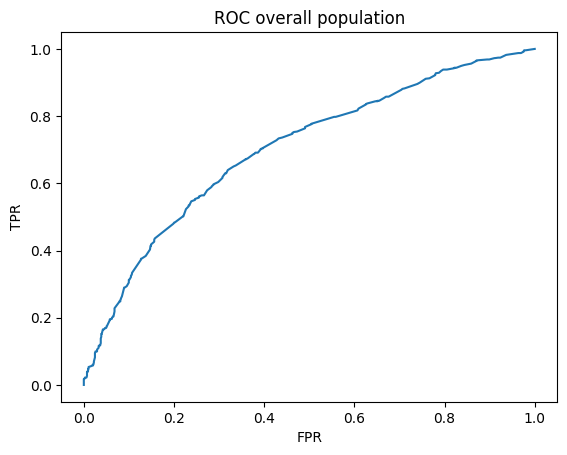

ROC AUC:  0.7011956758767542


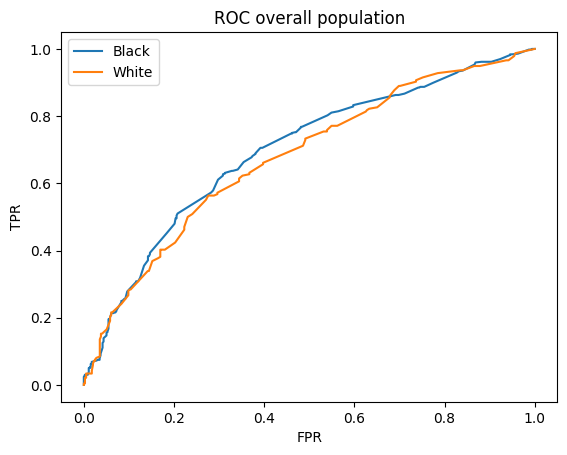

ROC AUC Black:  0.6951718783087456
ROC AUC White:  0.6763838232139026


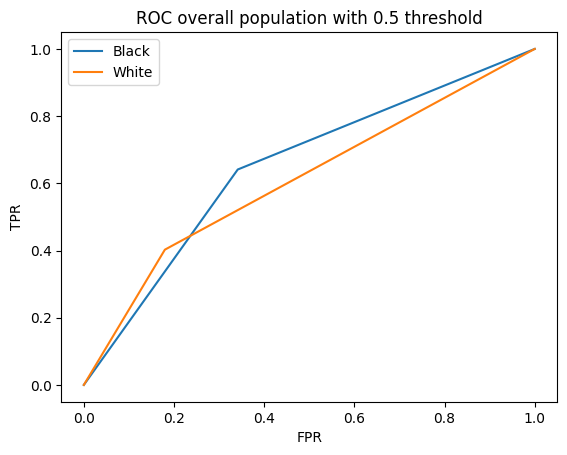

Black
actual   False  True 
guessed              
False      301    178
True       156    318

Accuracy:  0.6495278069254984
PPV:  0.6708860759493671
TPR:  0.6411290322580645
FPR:  0.3413566739606127
FNR:  0.3588709677419355
White
actual   False  True 
guessed              
False      324    141
True        71     95

Accuracy:  0.6640253565768621
PPV:  0.572289156626506
TPR:  0.4025423728813559
FPR:  0.17974683544303796
FNR:  0.597457627118644


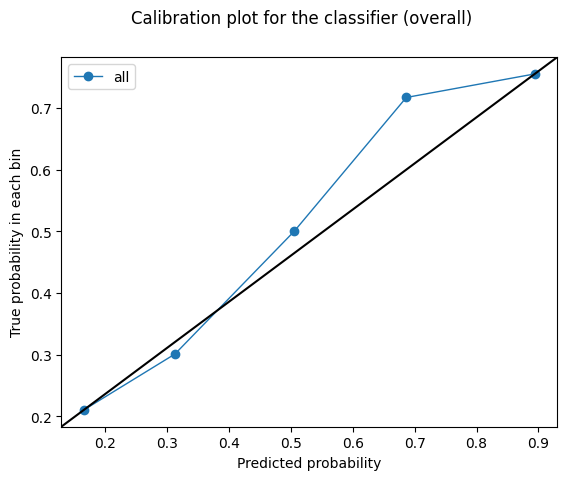

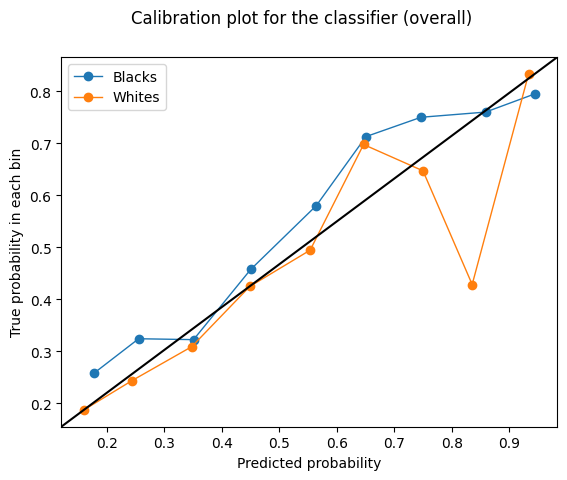

In [ ]:
# @title
from sklearn.linear_model import LogisticRegression # 1. choose model class

model = LogisticRegression(random_state=5) # 2. instantiate model

model.fit(X_train, y_train) # 3. fit model to data

y_pred = model.predict(X_test) # 4. predict on new data

print('Accuracy:', accuracy_score(y_test, y_pred))

calculate_fairness(y_test,y_pred) # Calculate fairness in terms of demographic and predictive parity

create_all_graphs(X_test, X_test_b, y_test_b, X_test_w, y_test_w)

# Analysis of Disparities in Classification Results

After classifying the data with the logistic regression model, our analysis mainly focused on disparities between the predicted classifications of two races (Caucasian and African-American). Here are the key findings:

### Accuracy: General
The general accuracy of the prediction was found to be 0.6553, indicating that the model performs relatively the same as the COMPAS model.

### ROC Curve: General
The ROC curve plotted on the overall population showed that our classifier doesn't predict a really good level of separability between the negative and positive classes, with a ROC AUC of 0.701. A good AUC score is usually 80% or higher.

### ROC Curve: Black vs White
The ROC curve showed somewhat similar levels of separability for both racial groups, with some small divergence observed in certain areas. The AUC score for Blacks was   0.695 while the ROC AUC for Whites: was 0.676.

### Accuracy with Common Threshold
It was observed that for blacks, the false positive rate (FPR) was comparatively higher (around 0.34) than for whites(around 0.17), indicating that more blacks were misclassified as high-risk. Similarly, for whites, the false negative rate (FNR) was much higher(around 0.59) than for blacks(around 0.35), indicating them being classified as low risk versus black.

### Calibration Plot: General
The calibration plot shows that it's not a perfect classification, as the line deviates from the diagonal at various points, indicating over and under-estimations predicted by the classifier. The predicted line still lies close to the diagonal, but when we generalize it, we can easily say that the predictions are going to have misclassifications. For example, we can observe some under-classification between the predicted values of 0.5-0.8 on the plot.

### Calibration Plot: Black vs White
The calibration plot of blacks and whites was mostly closer to the diagonal lines, with similar kinds of deviations in the start and mid for both races. However, we observe a huge disparity as the calibration plot shows that for higher predicted values for whites (e.g., between 0.8-0.9), the true probability score was way less (around 0.4), indicating a clear overestimation by the model for them compared to blacks.

# k-nearest neighbors (n=3)

Accuracy: 0.6161616161616161

demographic_parity_difference: 
0.27010873993710743

demographic_parity_ratio: 
0.47466606293864616

equalized_odds_difference: 
0.3114406779661017

equalized_odds_ratio: 
0.5016949152542373

sufficiency: 
Chi-square statistic: 113.68296323222077
P-value: 1.5290120645042538e-26
Degrees of freedom: 1
Expected frequencies table:
 [[565.54292929 387.45707071]
 [374.45707071 256.54292929]]

 guessed    0    1  positive_rate
race                            
black    463  490       0.514166
white    477  154       0.244057


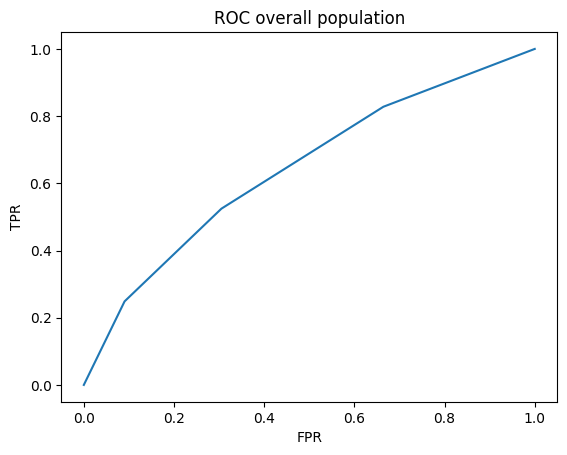

ROC AUC:  0.643936478616691


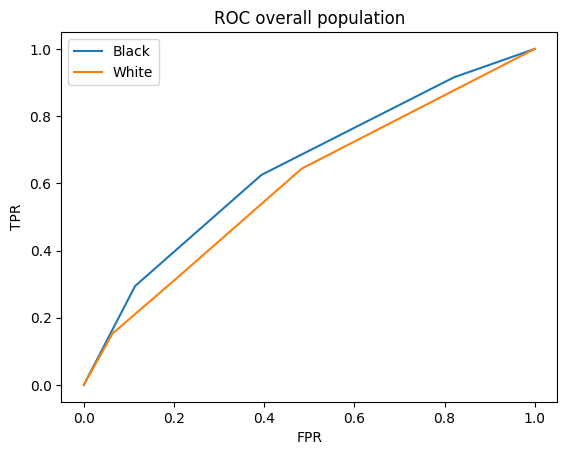

ROC AUC Black:  0.6459553892849581
ROC AUC White:  0.5963741686333405


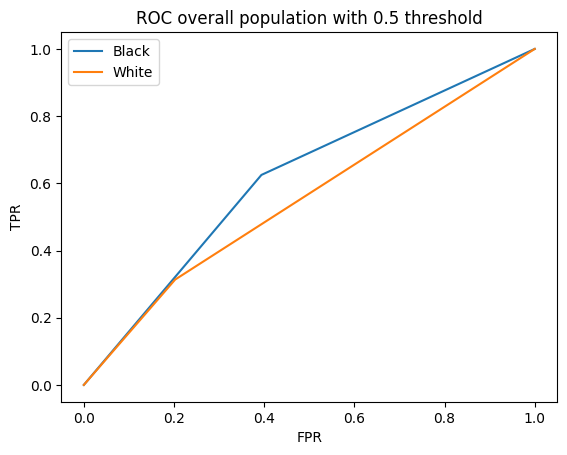

Black
actual   False  True 
guessed              
False      277    186
True       180    310

Accuracy:  0.6159496327387198
PPV:  0.6326530612244898
TPR:  0.625
FPR:  0.3938730853391685
FNR:  0.375
White
actual   False  True 
guessed              
False      315    162
True        80     74

Accuracy:  0.6164817749603804
PPV:  0.4805194805194805
TPR:  0.3135593220338983
FPR:  0.20253164556962025
FNR:  0.6864406779661016


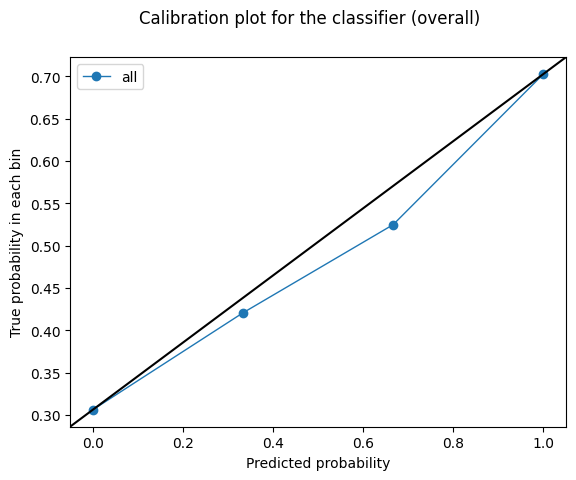

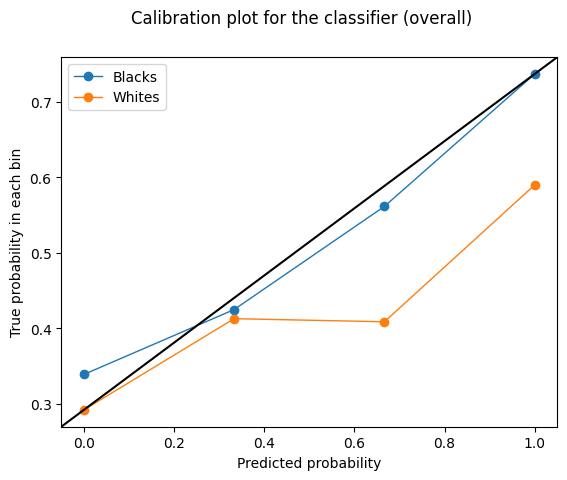

In [ ]:
from sklearn.neighbors import KNeighborsClassifier # 1. choose model class

model = KNeighborsClassifier(n_neighbors=3) # 2. instantiate model

model.fit(X_train, y_train) # 3. fit model to data

y_pred = model.predict(X_test) # 4. predict on new data

print('Accuracy:', accuracy_score(y_test, y_pred))
calculate_fairness(y_test,y_pred) # Calculate fairness in terms of demographic and predictive parity
create_all_graphs(X_test, X_test_b, y_test_b, X_test_w, y_test_w)

# Analysis of Disparities in Classification Results

After classifying the data with the new classifier, we examined the disparities between the predicted classifications of two races (Caucasian and African-American). Here are the key findings:

### Accuracy: General
The general accuracy of the prediction was found to be 0.616, indicating that the model doesn't do a good job on predictions.

### ROC Curve: General
The ROC curve plotted on the overall population showed that our classifier predicted a decent level of separability between the negative and positive classes. However, the area under the curve (AUC) obtained this time(0.64) is lesser than the logistic regression(0.70), indicating that the classifier behaves poorly compared to logistic regression and makes more mistakes relatively.

### ROC Curve: Black vs White
Similarly, the AUC for both blacks and whites(ROC AUC Black:  0.64
ROC AUC White:  0.59)  is lesser than the logistic regression classifier. Comparing them, we observe that the AUC for whites is even lesser than for blacks, indicating more misclassification for them.

### Accuracy with Common Threshold
FPR for both races is comparable and similar for both but the whites have FNR higher than the blacks indicating that the model shows some leniency towards whites when they should have a high-risk score but the model classifies them to be labeled as low-risk.

### Calibration Plot: General
The calibration plot shows that the model's calibration generally follows the diagonal line, indicating that it's fairly well-calibrated. However, there is some deviation from the perfect calibration line in the mid-range (between 0.4-0.6), where the model appears to be overestimating probabilities.

### Calibration Plot: Black vs White
The model seems to be well calibrated for blacks generally, with a small disparity at around the predicted probability of 0.2-0.5, showing some overestimates. However, for whites, the model is shown to be extremely poorly calibrated because, after 0.0 - 0.1, all the predicted probabilities are an overestimation of true probabilities. For example, for a predicted value of 0.7 for whites, the true predicted probability is around 0.2.

## Naive Bayes: Gaussian NB

Accuracy: 0.6268939393939394

demographic_parity_difference: 
0.4926556058688636

demographic_parity_ratio: 
0.23782338897235883

equalized_odds_difference: 
0.5169491525423728

equalized_odds_ratio: 
0.19914920107906203

sufficiency: 
Chi-square statistic: 370.28100926566674
P-value: 1.6255852144852735e-82
Degrees of freedom: 1
Expected frequencies table:
 [[524.02967172 428.97032828]
 [346.97032828 284.02967172]]

 guessed    0    1  positive_rate
race                            
black    337  616       0.646380
white    534   97       0.153724


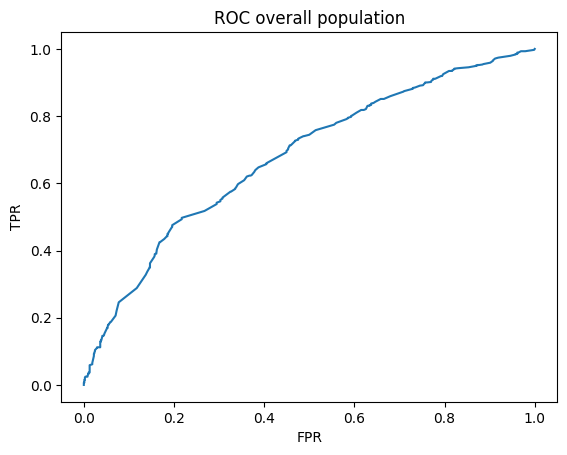

ROC AUC:  0.6778802367941714


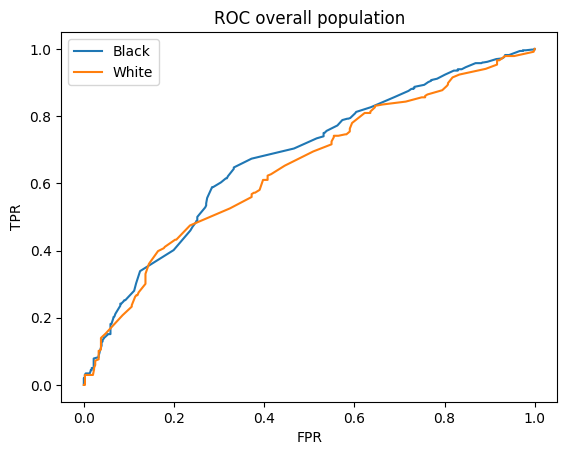

ROC AUC Black:  0.6767796640079058
ROC AUC White:  0.6466048058356576


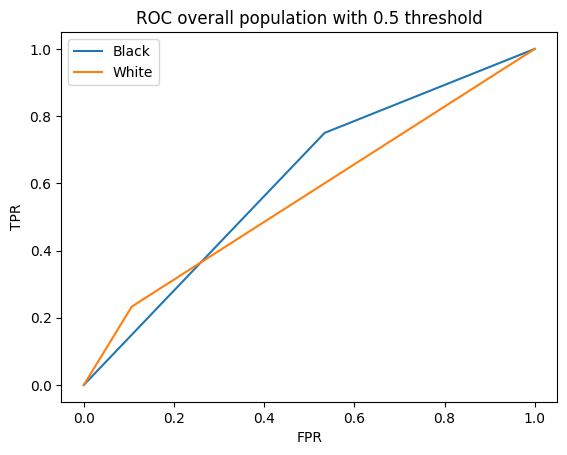

Black
actual   False  True 
guessed              
False      213    124
True       244    372

Accuracy:  0.6138509968520461
PPV:  0.6038961038961039
TPR:  0.75
FPR:  0.5339168490153173
FNR:  0.25
White
actual   False  True 
guessed              
False      353    181
True        42     55

Accuracy:  0.6465927099841522
PPV:  0.5670103092783505
TPR:  0.2330508474576271
FPR:  0.10632911392405063
FNR:  0.7669491525423728


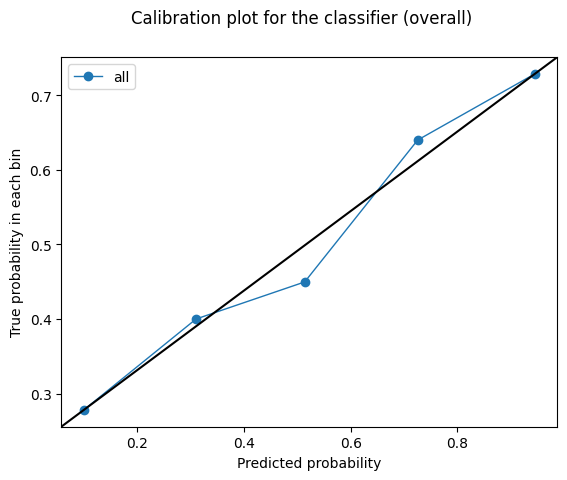

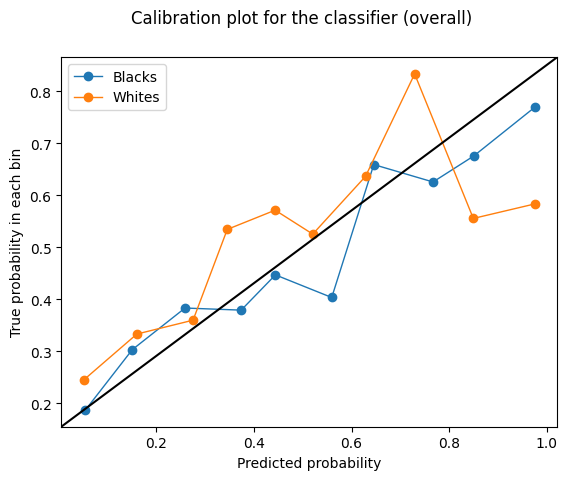

In [ ]:
from sklearn.naive_bayes import GaussianNB # 1. choose model class

model = GaussianNB() # 2. instantiate model

model.fit(X_train, y_train) # 3. fit model to data

y_pred = model.predict(X_test) # 4. predict on new data

print('Accuracy:', accuracy_score(y_test, y_pred))

calculate_fairness(y_test,y_pred) # Calculate fairness in terms of demographic and predictive parity

create_all_graphs(X_test, X_test_b, y_test_b, X_test_w, y_test_w)

# Analysis of Disparities in Classification Results

After classifying the data with the new classifier, we examined the disparities between the predicted classifications of two races (Caucasian and African-American). Here are the key findings:

### Accuracy: General
The general accuracy of the prediction was found to be 0.62, which is a bit better than K-NN but less than linear regression and COMPAS classifier

### ROC Curve: General
The ROC curve plotted on the overall population showed that our classifier predicted a decent level of separability between the negative and positive classes. However, the area under the curve (AUC) obtained this time(0.67) is lesser than the linear regression, indicating that the classifier doesn't behave as well as linear regression and makes more mistakes relatively.

### ROC Curve: Black vs White
Similarly, the AUC for both blacks and whites(ROC AUC Black:  0.67
ROC AUC White:  0.64) are comparable to the other classifiers. Comparing them, we observe that the AUC for both whites and blacks is quite comparable but when we see the actual classification, we see that the model is inclined to classify more blacks as False positives.

### Accuracy with Common Threshold
The classifier seems to be more sensitive for the Black group but less specific, as indicated by the high TPR and FPR. In contrast, it is more specific but less sensitive for the White group.

### Calibration Plot: General
The calibration plot shows that the model's calibration is not following the diagonal line, indicating that it's poorly calibrated. The actual line remains below the perfect calibration line showing overestimations in almost all the values showing the predicted probability to be higher than the true probability. From this, we can infer that for most of the data, we will be getting higher risk scores for individuals making them highly likely to receive legal consequences.

### Calibration Plot: Black vs White
Neither group seems to be perfectly calibrated. Both lines show points above and below the diagonal, indicating overestimation and underestimation of risks at different probability levels.
The line for Blacks seems to overpredict the risk (points are below the diagonal) at low predicted probabilities but gets closer to the diagonal as predicted probabilities increase. However, the line's fluctuation indicates inconsistency in the model's calibration for this group.
The line for Whites exhibits a more noticeable deviation from the diagonal. Particularly at higher predicted probabilities, the true probability sharply drops, suggesting that the model significantly overestimates the risk for Whites at high predicted probability bins. At around 0.8 there is a sharp drop in the true probability for Whites at this predicted probability, suggesting the model highly overestimates the risk for this group at this level.

### On Naive Bayes
Naive Bayes is known as a good classifier but not as a good estimator.

Naive Bayes assumes that all features are independent which allows an easy classification. This is since we can just multiply the conditioned probabilities that a feature occurs given a class.  

This is unrealisitc in the real world, so why does Naive Bayes classify so well?

Zhang found out, that the local dependencies either support each other or cancel each other out up to a certain point. This makes it similar to independent features and thus explains the good classification performance. https://www.cs.unb.ca/~hzhang/publications/FLAIRS04ZhangH.pdf


However, the independence assumption does not allow good estimations. Hence, this explains the way the calibration curve looks.

## Classifier Comparison

| Metric                     | Naive Bayes | Logistic Regression | k-NN    |
|----------------------------|-------------|---------------------|---------|
| **Accuracy: General**      | 0.62        | 0.65 | 0.61 |
| **ROC AUC: General**       | 0.67        | 0.70 | 0.64 |
| **ROC AUC Black**          | 0.67        | 0.69 | 0.64 |
| **ROC AUC White**          | 0.64        | 0.67 | 0.59 |

### Summary

- **Accuracy:** Naive Bayes and KNN performs comparable to each others but are less accurate.
- **ROC AUC:** K-NN has the lowest AUC which is slightly lower than k-NN.
- **ROC AUC Black vs White:** Naive Bayes shows similar performance to the previous classifiers in distinguishing between the two races.But logistic regression is geenrally the one with the highest numbers
- Based on accuracy scores and calculation of confusion matrix in each classifier we see that the FPR for blacks was higher than whites for all the classifier showing that more blacks were misclassified as high risk as compared to whites.
- Based on the calibration plots, we see that logistic regression performs better than all the other classifier as an indicator of true vs predict probability with least mis classifications.


# **Fair Classifiers**

# Notion of Fairness

After training different classifiers on the compass data and comparing the outcomes based on their accuracy, TPR, FPR, ROC, and calibration curves, we moved on to the next phase of our work where we needed to train a fair classifier. But to do this, it is necessary that we first clearly define a clear and precise notion of fairness that will help us tweak the process of training a classifier and arrive at a point where it fairly predicts the outcomes.

In mathematical and machine learning terms, we can formalize the concepts of popular notions of fairness through the following parameters:

- **Independence** (also called demographic/statistical parity/individual fairness): This is achieved when the outcome of predictions by a machine learning model is not dependent on data belonging to a sensitive group. This means that we have an average equal outcome rate across all the groups. Mathematically, we can express this as:

    P(Y | A=a) = P(Y | A=b)

It ignores any correlation between Y and A. Failing to achieve demographic parity could result in biased outcomes that can also be defined in terms of allocation harms (reference) which, in our case, relates to stereotypical harm. In general, while comparing multiple groups, we can use it to deduce the extent of bias, but that might not reflect the ground reality due to the absence of meaningful context. For example, we can easily say that the probability of a certain outcome should be similar for all categories under discussion, but this is only valid if we can accurately say that the data is an inaccurate representation of the ground truth.

- **Separation** (also called equalized odds/group fairness): Equal performance, and error rates within each group. Considering this notion of fairness, the goal is to achieve equal false and true positive rates for each group under discussion. It also means that it gives a more restricted view than demographic parity because we not only make the prediction independent of the groups involved but also focus on the outcomes. It can be mathematically formalized as:

    P(R=r | Y = y, A = a) = P(R=r | Y = y, A = b)

Where R is the FPR+TPR, Y is the prediction, and A is the sensitive attribute. This kind of notion helps us in diagnosing whether the model is behaving equally for all groups under discussion.

- **Sufficiency** s: Considering the probability scores obtained as an outcome of training a model, we observe that the probability of the outcome Y to be 1 is independent of the sensitive attribute A. We can say that the probability scores are sufficient to predict Y, and it does not depend on sensitive attributes. This would ensure that choices have the same accuracy per group. In mathematical terms, we write:

    P(Y = y | R = r, A = a) = P(Y = y | R = r, A = b)

And say that R is sufficient to predict Y.


# Fairness Rating of the Models

We derive the fairness rating of the models based on the notions of fairness mentioned previously and also briefly compare the COMPAS classifier along with the few classifiers we trained and explained previously. The functions used to determine the ratios can be found in the above code as part of the helper functions under calculate_fairness. Here we are using a Python library referenced at the end called Fairlearn that provides out-of-the-box methods to service these ratios.


# Comparing Positive Rate and TPR

| Model                   | Positive Rate | True Positive Rate |
|-------------------------|---------------|--------------------|
| Compas White            | 33.09%        | 50.36%             |
| Compas Black            | 57.60%        | 71.52%             |
| Logistic Regression White | 26.30%      | 40.25%             |
| Logistic Regression Black | 49.73%      | 64.11%             |
| 3-NN White              | 24.40%        | 31.35%            |
| 3-NN Black              | 51.41%        | 62.50%            |
| Naive Bayes White       | 15.37%        | 23.30%             |
| Naive Bayes Black       | 64.63%        | 75.00%             |



# Fairness Comparison

| Model                   | Independence | Separation | Sufficiency |
|-------------------------|--------------|------------|-------------|
| Compas                  | 0.28            | 0.17          | 479.75           |
| Logistic Regression     | 0.52           | 0.52          |85.58  |
| 3-NN                    | 0.47           | 0.50        | 113.68   |
| Naive Bayes             | 0.23           | 0.19         |370.28   |


# Comments
- COMPAS: This extremely low value indicates a very high level of disparity in positive prediction rates among different demographic groups, A very high sufficiency suggests strong corelations between sensitive attribute and predictiions.
- Logistic Regression: This model exhibits moderate bias. But it is nevertheless biased since the demographic parity ratio and statistical parity are far from 1, indicating that the model neither has group fairness nor individual fairness. A moderate value for sufficiency suggests that sensitive attribute is moderately corelated with the predictions
- 3-NN: This value also suggests significant level of bias, as a perfect score (indicating complete fairness) would be closer to 1, and the sufficiency represents that this model is very biased. Strong corelation between sensitive attribute and predictions was found.
- Naive Bayes: This extremely low value indicates a very high level of disparity in positive prediction rates among different demographic groups, suggesting this model is the least fair among the three according to every fairness metric we have.



# Train a fair classifier

To obtain a fair classifier there are three approaches: Either you can preprocess the data to remove bias, you can do in-processing which means to adjust the classifier via fairness constraints or you can post-process the model outcome to make it more fair https://arxiv.org/abs/2012.15816. We decided to focus on a pre-processing method namely our method because this tackles the problem, namely, the bias in the data, at its root while still keeping the accuracy almost as high as before.

## Removing sensitive feature from classifiers

In [ ]:
# @title
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from collections import defaultdict

FEATURES_CLASSIFICATION = ["age_cat", "sex", "priors_count", "c_charge_degree"] #features to be used for classification
CONT_VARIABLES = ["priors_count"] # continuous features, will need to be handled separately from categorical features, categorical features will be encoded using one-hot
CLASS_FEATURE = "two_year_recid" # the decision variable
SENSITIVE_ATTRS = ["race"]
#sensitive_features = data[SENSITIVE_ATTRS]

y = data[CLASS_FEATURE]
X = np.array([]).reshape(len(y), 0) # empty array with num rows same as num examples, will hstack the features to it
x_control = defaultdict(list)

for attr in FEATURES_CLASSIFICATION:
    vals = data[attr]
    if attr in CONT_VARIABLES:
        vals = [float(v) for v in vals]
        vals = preprocessing.scale(vals) # 0 mean and 1 variance
        vals = np.reshape(vals, (len(y), -1)) # convert from 1-d arr to a 2-d arr with one col

    else: # this encodes categorical variables in a numerical way -- there are other ways to do it
        enc = preprocessing.LabelBinarizer()
        enc.fit(vals)
        vals = enc.transform(vals)

    # add to learnable features
    X = np.hstack((X, vals))


# the following is a very dirty way to keep track of the race after the train_test_split
ind = data["race"]=="African-American"
X_b = X[ind]
y_b = y[ind]
ind = data["race"]=="Caucasian"
X_w = X[ind]
y_w = y[ind]


X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_b, y_b, test_size=0.3, random_state=1234)
X_train_w, X_test_w, y_train_w, y_test_w = train_test_split(X_w, y_w, test_size=0.3, random_state=5678)

X_train = np.vstack((X_train_b, X_train_w))
y_train = np.hstack((y_train_b, y_train_w))
X_test = np.vstack((X_test_b, X_test_w))
y_test = np.hstack((y_test_b, y_test_w))

In [ ]:
model = LogisticRegression(random_state=5) # 2. instantiate model

model.fit(X_train, y_train) # 3. fit model to data

y_pred = model.predict(X_test) # 4. predict on new data

print('Accuracy:', accuracy_score(y_test, y_pred))

calculate_fairness(y_test,y_pred) # Calculate fairness in terms of demographic and predictive parity

Accuracy: 0.6553030303030303

demographic_parity_difference: 
0.23430222019712543

demographic_parity_ratio: 
0.5289240171986065

equalized_odds_difference: 
0.2385866593767086

equalized_odds_ratio: 
0.5265660499837714

sufficiency: 
Chi-square statistic: 85.58191860495762
P-value: 2.2229888555452713e-20
Degrees of freedom: 1
Expected frequencies table:
 [[567.94949495 385.05050505]
 [376.05050505 254.94949495]]

 guessed    0    1  positive_rate
race                            
black    479  474       0.497377
white    465  166       0.263074


In [ ]:
model = KNeighborsClassifier(n_neighbors=50) # 2. instantiate model

model.fit(X_train, y_train) # 3. fit model to data

y_pred = model.predict(X_test) # 4. predict on new data

print('Accuracy:', accuracy_score(y_test, y_pred))
calculate_fairness(y_test,y_pred) # Calculate fairness in terms of demographic and predictive parity

Accuracy: 0.6590909090909091

demographic_parity_difference: 
0.22975905597969876

demographic_parity_ratio: 
0.5772965630334885

equalized_odds_difference: 
0.23995352651722257

equalized_odds_ratio: 
0.6053871062702385

sufficiency: 
Chi-square statistic: 79.9828015889124
P-value: 3.776828900914414e-19
Degrees of freedom: 1
Expected frequencies table:
 [[522.22474747 430.77525253]
 [345.77525253 285.22474747]]

 guessed    0    1  positive_rate
race                            
black    435  518       0.543547
white    433  198       0.313788


For this test, we used k=50 and it gave us much better results in terms of accuracy and fairness.

In [ ]:
model = GaussianNB() # 2. instantiate model

model.fit(X_train, y_train) # 3. fit model to data

y_pred = model.predict(X_test) # 4. predict on new data

print('Accuracy:', accuracy_score(y_test, y_pred))

calculate_fairness(y_test,y_pred) # Calculate fairness in terms of demographic and predictive parity


Accuracy: 0.6553030303030303

demographic_parity_difference: 
0.2091185895570415

demographic_parity_ratio: 
0.5571332981158655

equalized_odds_difference: 
0.20813969382176045

equalized_odds_ratio: 
0.5585333915320821

sufficiency: 
Chi-square statistic: 68.97931558433137
P-value: 9.950156489930467e-17
Degrees of freedom: 1
Expected frequencies table:
 [[582.38888889 370.61111111]
 [385.61111111 245.38888889]]

 guessed    0    1  positive_rate
race                            
black    503  450       0.472193
white    465  166       0.263074


# Fairness Comparison

| Model                   | Independence | Separation | Sufficiency |
|-------------------------|--------------|------------|-------------|
| Logistic Regression     | 0.52           | 0.52          |85.58  |
| 50-NN                    | 0.57           | 0.60        |79.98    |
| Naive Bayes             | 0.55           | 0.55         |68.97   |


The accuracy was about 65% for all three classifiers.

# Comments
We can see that while it was "fairer" to train the classifier without using the sensitive attribute, it did not mitigate the bias completely. A large value for sufficiency (chi-square statistic and extremely small P-value) shows that there is still a strong correlation between sensitive attributes and the predicted outcomes. But in terms of group and individual fairness, we are doing a bit better. We see a significant improvement in the accuracy of all the models, we believe this is because as the model was blind towards race, it put more weightage on other decision features. However, this increased weightage still propagated biases in the model. The reasons for this can be:
This is because of the training data.  

1.   There might be historical biases in the data that can not be easily proven.
2.   Some features are acting as a proxy for race and still inducing bias in the model. We did see that blacks recidivate more than whites from the actual data. So maybe the model is inheriting that bias from some proxy feature.
3.   Complex feature interaction, like priors_count and age combined maybe can induce bias towards certain racial groups. We can't say this for sure but this can happen that 2 relevant features, when used together, can induce biases in the model towards blacks.

We need advanced measures to increase fairness in the data.

# Counterfactual Test World

We also tried to train the classifiers on the normal training data but modify the test data to be from a counterfactual world i.e. we changed the attribute being white to being black and vice versa.

In [ ]:
FEATURES_CLASSIFICATION = ["age_cat", "race", "sex", "priors_count", "c_charge_degree"] #features to be used for classification
CONT_VARIABLES = ["priors_count"] # continuous features, will need to be handled separately from categorical features, categorical features will be encoded using one-hot
CLASS_FEATURE = "two_year_recid" # the decision variable
SENSITIVE_ATTRS = ["race"]
#sensitive_features = data[SENSITIVE_ATTRS]

y = data[CLASS_FEATURE]
X = np.array([]).reshape(len(y), 0) # empty array with num rows same as num examples, will hstack the features to it
x_control = defaultdict(list)

for attr in FEATURES_CLASSIFICATION:
    vals = data[attr]
    if attr in CONT_VARIABLES:
        vals = [float(v) for v in vals]
        vals = preprocessing.scale(vals) # 0 mean and 1 variance
        vals = np.reshape(vals, (len(y), -1)) # convert from 1-d arr to a 2-d arr with one col

    else: # this encodes categorical variables in a numerical way -- there are other ways to do it
        enc = preprocessing.LabelBinarizer()
        enc.fit(vals)
        vals = enc.transform(vals)

    # add to learnable features
    X = np.hstack((X, vals))


# the following is a very dirty way to keep track of the race after the train_test_split
ind = data["race"]=="African-American"
X_b = X[ind]
y_b = y[ind]
ind = data["race"]=="Caucasian"
X_w = X[ind]
y_w = y[ind]

X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_b, y_b, test_size=0.3, random_state=1234)
X_train_w, X_test_w, y_train_w, y_test_w = train_test_split(X_w, y_w, test_size=0.3, random_state=5678)

X_train = np.vstack((X_train_b, X_train_w))
y_train = np.hstack((y_train_b, y_train_w))
X_test = np.vstack((X_test_b, X_test_w))
y_test = np.hstack((y_test_b, y_test_w))

X_test_counterfactual = X_test.copy()
for i in range(len(X_test)):
  if X_test[i][3] == 1:
    X_test_counterfactual[i][3]=0
    X_test_counterfactual[i][5]=1
  elif X_test[i][5] == 1:
    X_test_counterfactual[i][3]=1
    X_test_counterfactual[i][5]=0

In [ ]:
model = LogisticRegression(random_state=5) # 2. instantiate model

model.fit(X_train, y_train) # 3. fit model to data

y_pred = model.predict(X_test_counterfactual) # 4. predict on counterfactual data

print('Accuracy:', accuracy_score(y_test, y_pred))

calculate_fairness(y_test,y_pred) # Calculate fairness in terms of demographic and predictive parity

Accuracy: 0.6553030303030303

demographic_parity_difference: 
0.23430222019712543

demographic_parity_ratio: 
0.5289240171986065

equalized_odds_difference: 
0.2385866593767086

equalized_odds_ratio: 
0.5265660499837714

sufficiency: 
Chi-square statistic: 85.58191860495762
P-value: 2.2229888555452713e-20
Degrees of freedom: 1
Expected frequencies table:
 [[567.94949495 385.05050505]
 [376.05050505 254.94949495]]

 guessed    0    1  positive_rate
race                            
black    479  474       0.497377
white    465  166       0.263074


In [ ]:
model = KNeighborsClassifier(n_neighbors=5) # 2. instantiate model

model.fit(X_train, y_train) # 3. fit model to data

y_pred = model.predict(X_test_counterfactual) # 4. predict on counterfactual data

print('Accuracy:', accuracy_score(y_test, y_pred))
calculate_fairness(y_test,y_pred) # Calculate fairness in terms of demographic and predictive parity

Accuracy: 0.6218434343434344

demographic_parity_difference: 
0.09238487851359373

demographic_parity_ratio: 
0.7652192287374538

equalized_odds_difference: 
0.06674237597983546

equalized_odds_ratio: 
0.7653748782862707

sufficiency: 
Chi-square statistic: 13.720967902540337
P-value: 0.00021207355320413738
Degrees of freedom: 1
Expected frequencies table:
 [[613.07260101 339.92739899]
 [405.92739899 225.07260101]]

 guessed    0    1  positive_rate
race                            
black    578  375       0.393494
white    441  190       0.301109


In [ ]:
model = GaussianNB() # 2. instantiate model

model.fit(X_train, y_train) # 3. fit model to data

y_pred = model.predict(X_test_counterfactual) # 4. predict on counterfactual data

print('Accuracy:', accuracy_score(y_test, y_pred))

calculate_fairness(y_test,y_pred) # Calculate fairness in terms of demographic and predictive parity


Accuracy: 0.6047979797979798

demographic_parity_difference: 
0.09750841034151886

demographic_parity_ratio: 
0.7833527925158507

equalized_odds_difference: 
0.14089133866991663

equalized_odds_ratio: 
0.6264961156065969

sufficiency: 
Chi-square statistic: 14.746224073530628
P-value: 0.00012299359335477537
Degrees of freedom: 1
Expected frequencies table:
 [[579.98232323 373.01767677]
 [384.01767677 246.98232323]]

 guessed    0    1  positive_rate
race                            
black    617  336       0.352571
white    347  284       0.450079


# Fairness Comparison

| Model                   | Independence | Separation | Sufficiency | Accuracy |
|-------------------------|--------------|------------|-------------|----------|
| Logistic Regression     | 0.52           | 0.52          |85.58  | 65% |
| 5-NN                    | 0.76           | 0.76        | 13.72   | 62% |
| Naive Bayes             | 0.78           | 0.62         |14.74   | 60% |


We can see that the accuracy is similar to the accuracy of the classifiers on the original data. However the bias was mitigated. We achieved high improvements on the fairness criteria.

This might be due to a combination of the previous results: the model might see some correlation in the data even without the race. However the race strengthens this correlation. By changing the race these correlations equalize each other, leaving us with a fairer classifier. But this approach modifies the value for original feature and changes the ground truth which is not really what we want to do in real world. But this was an interesting approach to study the corelation.

# Bias Mitigation Algorithms for a Fair Classification

In the second phase of the project, we tried to train some supervised learning models on our data set and compared their fairness in detail. Generally, it is assumed to achieve a decent level of accuracy with such classifiers but found that these classifiers were not void of bias in all cases and we have summarized the bias as well in the above sections. The problem we observed with them is not the classifier in itself but the actual data which we infer to be biased and hence whatever classifier we train on it, it inherits the bias.

We also saw that just removing the protected attribute was not enough because there was still an indirect impact that stays as is.

We dug further into various online resources and research articles that talk about fairness in data and learned about bias mitigation techniques and algorithms.

To obtain a fair classifier there are three approaches: Either you can preprocess the data to remove bias, you can do in-processing which means to adjust the classifier via fairness constraints or you can post-process the model outcome to make it more fair.

We decided to focus on pre-processing methods that focus on pre-processing the data at hand and change it into a transformed data set based on the remapping of the values preset in the initial distributions.
For this purpose, we consider and reference two approaches that we found. In the following sections, we have attempted to summarize the research papers and their relevant implementation that we chose to work on including the original work, python libraries that we found online relevant to this, etc.  



### Optimized Pre-Processing for Discrimination Prevention

1.   One of the approaches is based on the "[Optimized Pre-Processing for Discrimination Prevention](https://proceedings.neurips.cc/paper_files/paper/2017/file/9a49a25d845a483fae4be7e341368e36-Paper.pdf)" proposed in 2017. This approach introduces a probabilistic formulation of data pre-processing to reduce bias and discrimination in the predictions.

This approach focuses on the optimization of the initial data set and talks about remapping it completely such that it preserves and ensures the following properties:



*    Discrimination Control: Here the idea is to ensure that the outcome of the predictive model does not depend heavily on protected attributes such as race or gender. The goal is to ensure similar outcomes for all groups, a concept known as group fairness. The paper presents two formulations for this: A) Making the conditional distribution of the predicted outcome close to a target distribution for all values of the protected attribute represented as $$
J \Big(p\hat{Y}|D(y|d), pY_T(y)\Big) \leq \epsilon_{y,d} \quad \forall d \in D, y \in \{0,1\},
$$
 B) Ensuring the conditional probability of the outcome is similar for any two values of the protected attribute. Mathematically it is represented as:$$
J \Big(p\hat{Y}|D(y|d_1), p\hat{Y}|D(y|d_2)\Big) \leq \epsilon_{y,d_1,d_2} \quad \forall d_1, d_2 \in D, y \in \{0, 1\}.
$$
Where J is some distance function.D is the protected variables, X denotes nonprotected variables and Y is the outcome.


*  Distortion Control: It involves placing constraints on the transformation process to limit how much individual data points can be changed. This is to promote individual fairness by ensuring that similar individuals are treated similarly. Mathematically represented as: $$
E_\delta \Big( (x,y), (X,Y) \Big) | D=d, X=x, Y=y \leq c_{d,x,y} \quad \forall (d,x,y) \in D \times X \times Y.
$$
Here D is the protected variables, X denotes nonprotected variables and Y is the outcome. Sigma denotes the distortion function.

* Utility Preservation: This is to ensure that the data doesn't lose all the initial meaning and the important context namely utility. The distribution of the transformed data should be statistically close to the distribution of the original data to preserve its predictive power. Represented as $$
\Delta \Big( p_\hat{X,Y}, p_{X,Y} \Big)
$$


### Learning Fair Representations


2.  The other approach we tried is based on the ["Learning Fair Representations"](http://proceedings.mlr.press/v28/zemel13.html) paper proposed in 2013. The approach focuses on formulating this as a data optimization problem where the aim is to encode data in a way that the correlation with the protected group is hidden well. This again is a probabilistic distribution of the data in a way that it is in no way related to which protected group a data point belongs after the redistribution. Initially, the data is mapped to some intermediae prototype representation which is a probabilistic remapping of data and then further optimizations are performed over the prototype. The prototype should embody the fact that the membership to a protected group is lost and this is formulated using the notion of statistical parity that we also saw in the earlier sections. Mathematically this is represented as: $$
P(Z = k | x+ \in X+) = P(Z = k | x- \in X-), \forall k
$$
 Where X represents the data, Z is the multinomial random variable(where the values represent the prototypes), Y is the decision variable and X represents the data. S represents a binary decision of whether a person is a member of a protected set or not(S=1).X+ represents people who are members of the protected set, and X- represents nonmembers.

  We get clusters of such prototypes which are the actual aim of the represented model: Learn Fair Representation(LFR) which aims to find a good set of such prototypes such that the following properties are preserved:
* Mappings from X0 to Z preserve statistical parity.
* The new mapping should retain the information about X (except the protected attribute information)
* The mapping from X to Y(the binary decision) should be close to the desired decision classification.



# Implementation: Bias Mitigation Algorithms

TO show the above-mentioned classifiers, we used [AI Fairness 360](https://github.com/Trusted-AI/AIF360/tree/main) which is an extensible open-source library containing techniques developed by the research community to help detect and mitigate bias in machine learning models throughout the AI application lifecycle. AI Fairness 360 package is available in both Python and R.

# AFI360 Toolkit
They have out-of-the-box implementations and API functions available for implementing the preprocessing pipelines we have discussed in the above sections.

For our implementation, we referenced the following notebook examples and functions used:


1.   Optimized Preprocessing: https://github.com/Trusted-AI/AIF360/blob/main/examples/demo_optim_data_preproc.ipynb
2.   LFR: https://github.com/Trusted-AI/AIF360/blob/main/examples/demo_lfr.ipynb



In [ ]:
pip install aif360

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.7/259.7 kB 5.5 MB/s eta 0:00:00


In [ ]:
%matplotlib inline
# Load all necessary packages
import sys
sys.path.append("../")
import numpy as np
from tqdm import tqdm

from aif360.datasets import BinaryLabelDataset
from aif360.datasets import CompasDataset
from aif360.algorithms.preprocessing.optim_preproc import OptimPreproc
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions\
            import load_preproc_data_compas
from aif360.algorithms.preprocessing.optim_preproc_helpers.distortion_functions\
            import get_distortion_compas
from aif360.algorithms.preprocessing.optim_preproc_helpers.opt_tools import OptTools

pip install 'aif360[inFairness]'


In [ ]:
import shutil
import os

# Source file path
source_file = "compas-scores-two-years.csv"

# Destination directory
destination_directory = "/usr/local/lib/python3.10/dist-packages/aif360/data/raw/compas"

# Check if the destination directory exists, create it if it doesn't
if not os.path.exists(destination_directory):
    os.makedirs(destination_directory)

# Copy the file to the destination directory
shutil.copy(source_file, destination_directory)

print("File copied successfully.")


File copied successfully.


# Optimized Preprocessing Implementation
We dont clean the data manually here. AIF360 cleans and loads the data in binary label classifier for us. It cleans the data using the same strategy provied by pro publica.


In [ ]:
privileged_groups = [{'race': 1}]
unprivileged_groups = [{'race': 0}]
dataset_orig = load_preproc_data_compas(['race'])
optim_options = {
    "distortion_fun": get_distortion_compas,
    "epsilon": 0.05,
    "clist": [0.99, 1.99, 2.99],
    "dlist": [.1, 0.05, 0]
}

In [ ]:
OP = OptimPreproc(OptTools, optim_options,
                  unprivileged_groups = unprivileged_groups,
                  privileged_groups = privileged_groups)

OP = OP.fit(dataset_orig)

# Transform training data and align features
dataset_transf = OP.transform(dataset_orig, transform_Y=True)
dataset_transf = dataset_orig.align_datasets(dataset_transf)

/usr/local/lib/python3.10/dist-packages/aif360/algorithms/preprocessing/optim_preproc.py:68: UserWarning: Privileged and unprivileged groups specified will not be used. The protected attributes are directly specified in the data preprocessing function. The current implementation automatically adjusts for discrimination across all groups. This can be changed by changing the optimization code.
  warn("Privileged and unprivileged groups specified will not be "
/usr/local/lib/python3.10/dist-packages/cvxpy/expressions/expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 1 times so far.

  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/cvxpy/expre

Optimized Preprocessing: Objective converged to 0.000000


The above results are in binary label dataset format provided by AIF360. We convert them to a Dataframe for ease of calculations an keeping our reasearch methodolgy consistent with the classifiers we trained earlier.

In [ ]:
df, attribs = dataset_transf.convert_to_dataframe() #convert to pandas datafram
data = df.to_dict('list')  # we coonvert this to a dictionary for ease of use and coherance.
for k in data.keys():
    data[k] = np.array(data[k])
data.keys()

dict_keys(['sex', 'race', 'age_cat=25 to 45', 'age_cat=Greater than 45', 'age_cat=Less than 25', 'priors_count=0', 'priors_count=1 to 3', 'priors_count=More than 3', 'c_charge_degree=F', 'c_charge_degree=M', 'two_year_recid'])

We see that this dataset and different columns preprocessing than what we did. For race, we had a one hot encoding but here since they only consider 2 races, we can have a binary value. Similarly, age, priors also dont use one hot encoding but are transformed several columns that represent categories. This is a bit similar to one hot though as one hot is also represented by several columns for each bit in the encoding.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from collections import defaultdict
import numpy as np

X = np.array([data[key] for key in data.keys() if key != 'two_year_recid']).T
Y = np.array(data['two_year_recid'])
# the following is a very dirty way to keep track of the race after the train_test_split
ind = data["race"]==0
X_b = X[ind]
y_b = Y[ind]
ind = data["race"]==1
X_w = X[ind]
y_w = Y[ind]

X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_b, y_b, test_size=0.3, random_state=1234)
X_train_w, X_test_w, y_train_w, y_test_w = train_test_split(X_w, y_w, test_size=0.3, random_state=5678)

X_train = np.vstack((X_train_b, X_train_w))
y_train = np.hstack((y_train_b, y_train_w))
X_test = np.vstack((X_test_b, X_test_w))
y_test = np.hstack((y_test_b, y_test_w))

Accuracy: 0.6584595959595959

demographic_parity_difference: 
0.03526273690722265

demographic_parity_ratio: 
0.9266257897978533

equalized_odds_difference: 
0.023963133640553025

equalized_odds_ratio: 
0.9601911387512737

sufficiency: 
Chi-square statistic: 1.75770278628019
P-value: 0.1849113077607181
Degrees of freedom: 1
Expected frequencies table:
 [[508.38699495 444.61300505]
 [336.61300505 294.38699495]]

 guessed  0.0  1.0  positive_rate
race                            
black    495  458       0.480588
white    350  281       0.445325


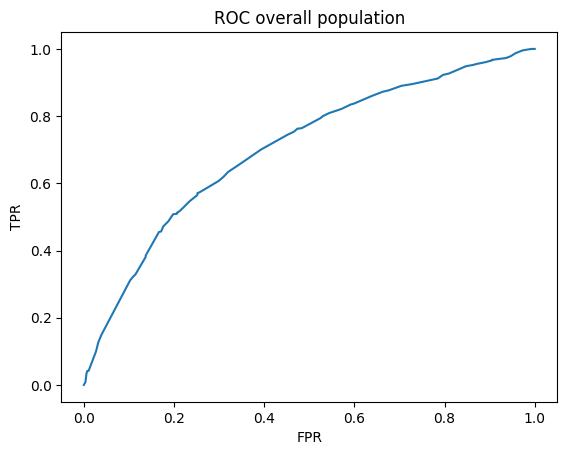

ROC AUC:  0.7047519972835662


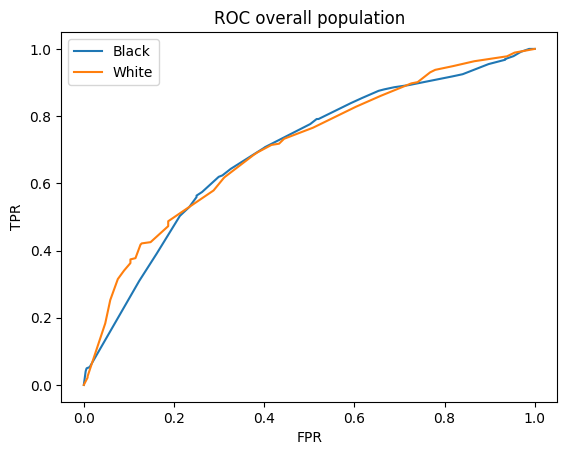

ROC AUC Black:  0.6956041776837651
ROC AUC White:  0.7067039106145252


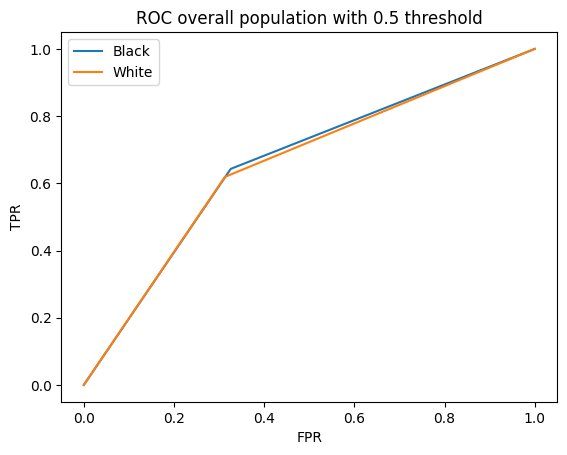

Black
actual   False  True 
guessed              
False      329    166
True       159    299

Accuracy:  0.6589716684155299
PPV:  0.6528384279475983
TPR:  0.6430107526881721
FPR:  0.32581967213114754
FNR:  0.35698924731182796
White
actual   False  True 
guessed              
False      246    104
True       112    169

Accuracy:  0.6576862123613312
PPV:  0.6014234875444839
TPR:  0.6190476190476191
FPR:  0.3128491620111732
FNR:  0.38095238095238093


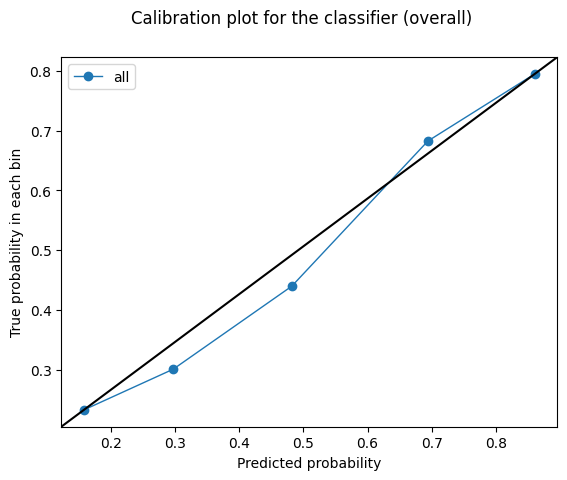

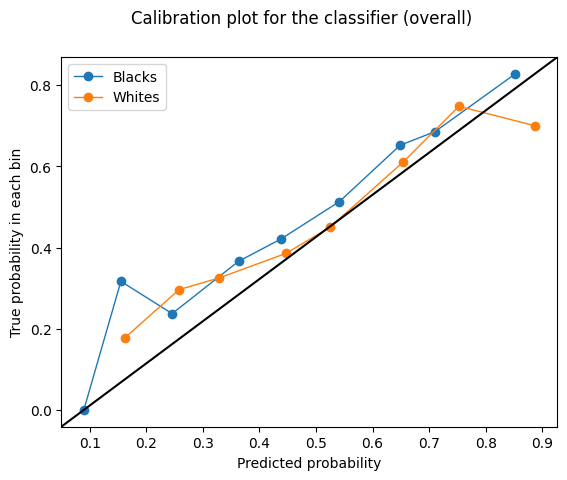

In [ ]:
# Apply logictic regression on the transformed data
model = LogisticRegression(random_state=5) # 2. instantiate model

model.fit(X_train, y_train) # 3. fit model to data

y_pred = model.predict(X_test) # 4. predict on new data

print('Accuracy:', accuracy_score(y_test, y_pred))

calculate_fairness(y_test, y_pred)
create_all_graphs(X_test, X_test_b, y_test_b, X_test_w, y_test_w)

# General Analysis

| Metric                     | Optimized Preprocessing |
|----------------------------|-------------|
| **Accuracy: General**      | 0.65        |
| **ROC AUC: General**       | 0.70        |
| **ROC AUC Black**          | 0.69        |
| **ROC AUC White**          | 0.70        |

# Fairness Comparison

| Model                   | Independence | Separation | Sufficiency |
|-------------------------|--------------|------------|-------------|
| Optimized Preprocessing | 0.92            | 0.96          | 1.75           |


# Comments
We can see that the classifier is extremely fair and we have mitigated the bias from the classifer. This is evident by every fairness metric that we have calculated. There is no corelation between the sensitive attribute and the predictions as shown by the extremly small chi-square statistic (sufficiency). demographic parity is and even odds ratio is close to zero. Indicating no favourable treatment for both priviliged and unprivileged groups. We can also see really small difference between FPR and FNR for both groups.



# LFR Implementation (INCOMPLETE due to time constraints)

Due to time constraints we could not dig deeper into implementing LFR in our research. But this can be an interesting thing for future improvements and research. The anlysis is below is **incomplete**.

In [ ]:
from aif360.algorithms.preprocessing.lfr import LFR

TR = LFR(unprivileged_groups=unprivileged_groups,
         privileged_groups=privileged_groups,
         k=10, Ax=0.1, Ay=1.0, Az=2.0,
         verbose=1
        )
TR = TR.fit(dataset_orig, maxiter=5000, maxfun=5000)
dataset_transf = TR.transform(dataset_orig)

In [ ]:
df, attribs = dataset_transf.convert_to_dataframe()
data = df.to_dict('list')
for k in data.keys():
    data[k] = np.array(data[k])
data.keys()

dict_keys(['sex', 'race', 'age_cat=25 to 45', 'age_cat=Greater than 45', 'age_cat=Less than 25', 'priors_count=0', 'priors_count=1 to 3', 'priors_count=More than 3', 'c_charge_degree=F', 'c_charge_degree=M', 'two_year_recid'])

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from collections import defaultdict
import numpy as np

X = np.array([data[key] for key in data.keys() if key != 'two_year_recid']).T
Y = np.array(data['two_year_recid'])
# the following is a very dirty way to keep track of the race after the train_test_split
ind = data["race"]==0
X_b = X[ind]
y_b = Y[ind]
ind = data["race"]==1
X_w = X[ind]
y_w = Y[ind]

X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_b, y_b, test_size=0.3, random_state=1234)
X_train_w, X_test_w, y_train_w, y_test_w = train_test_split(X_w, y_w, test_size=0.3, random_state=5678)

X_train = np.vstack((X_train_b, X_train_w))
y_train = np.hstack((y_train_b, y_train_w))
X_test = np.vstack((X_test_b, X_test_w))
y_test = np.hstack((y_test_b, y_test_w))

### References

- Hardt, M., Price, E., & Srebro, N. (2016). Equality of Opportunity in Supervised Learning. ArXiv. /abs/1610.02413
- Fairlearn User Guide : https://fairlearn.org/main/api_reference/generated/fairlearn.metrics.demographic_parity_difference.html#fairlearn.metrics.demographic_parity_difference
- Calmon, F., Wei, D., Vinzamuri, B., Natesan Ramamurthy, K., & Varshney, K. R. (2017). Optimized Pre-Processing for Discrimination Prevention. In I. Guyon, U. Von Luxburg, S. Bengio, H. Wallach, R. Fergus, S. Vishwanathan, & R. Garnett (Eds.), Advances in Neural Information Processing Systems (Vol. 30). Curran Associates, Inc. Retrieved from https://proceedings.neurips.cc/paper_files/paper/2017/file/9a49a25d845a483fae4be7e341368e36-Paper.pdf
- Zemel, R., Wu, Y., Swersky, K., Pitassi, T. &amp; Dwork, C.. (2013). Learning Fair Representations. <i>Proceedings of the 30th International Conference on Machine Learning</i>, in <i>Proceedings of Machine Learning Research</i> 28(3):325-333 Available from https://proceedings.mlr.press/v28/zemel13.html.
- An Introduction to Fairness in Machine Learning: https://medium.com/analytics-vidhya/an-introduction-to-fairness-in-machine-learning-62ef827e0020
- Optimized Preprocessing Notebook : https://github.com/Trusted-AI/AIF360/blob/main/examples/demo_optim_data_preproc.ipynb
- LFR Notebook: https://github.com/Trusted-AI/AIF360/blob/main/examples/demo_lfr.ipynb
- AFI360: https://github.com/Trusted-AI/AIF360/tree/main